# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv <= 3.4.2`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [31]:
import numpy as np
import skimage
from skimage import transform
from skimage import io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import random
from PIL import Image

# Helper functions

In [32]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [33]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean') 
    
    # Select Putative matches based on the distances 
    data = []
    tmp = []
    h,w = dist.shape
    for i in range(h):
        for j in range(w):
            if dist[i][j] <= 10000:
                tmp = list(kp1[i].pt+kp2[j].pt)
                data.append(tmp)
    data = np.array(data)
    return data
    
def cal_errors(H, data):
    """
    write your code to calculate the errors of model
    """
    num = len(data)
    p1 = np.hstack((data[:,:2],np.ones(( num,1))))
    p2 = data[:,2:]
                
    estimation = np.zeros((num,2))
    for i in range(num):
        # x, y = x/w, y/w 
        tmp = np.dot(H,p1[i])/np.dot(H,p1[i])[-1]
        estimation[i] = tmp[:2]
    
    errors = np.linalg.norm(p2 - estimation, axis=1) ** 2
    
    return errors
        

def compute_homography(data):
    """
    write your code to compute homography according to the matches
    """
    A = []
    for i in range(4):
        p1 = np.append(data[i][:2],1)
        p2 = np.append(data[i][2:],1)
        
        c1 = [0,0,0,p1[0],p1[1],p1[2],-p2[1]*p1[0],-p2[1]*p1[1],-p2[1]*p1[2]]
        c2 = [p1[0],p1[1],p1[2],0,0,0,-p2[0]*p1[0],-p2[0]*p1[1],-p2[0]*p1[2]]
        A.append(c1)
        A.append(c2)
        
    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    sv = V[-1,:].reshape((3,3))
    
    H = sv/sv[2,2]
    
    return H
    

def ransac(data, t, d):
    """
    write your ransac code to find the best model, inliers, and residuals
    :param data: a set of observed data points
    : param t: threshold value to determine whether a data point fits a model
    : param d: minimum number of inliers required
    """
    iterations = 10000 
    bestmodel = None
    best_inliers = None
    max_inliers = 0
    best_err = 9999999999
    for i in range(iterations):
        sub_index = random.sample(range(data.shape[0]), 4)
        subset = data[sub_index]
        
        H = compute_homography(subset)
        
        # if H is degenerate 
        if np.linalg.matrix_rank(H) < 3:
            continue

        # Get all inliers fitted the current model
        errors = cal_errors(H, data)
        index = np.where(errors < t)[0]
        inliers = data[index]
        
        # if total inliers number is larger than d and max_inliers, we update the model
        if len(inliers) >= d and len(inliers) >= max_inliers:
            curr_err = errors[index].sum() / len(inliers)
            if len(inliers) == max_inliers:
                # if the inliers number equals to max inliers number
                # check the residual
                if curr_err > best_err:  
                    continue
            
            best_err = errors[index].sum() / len(inliers)
            best_inliers = inliers.copy()
            bestmodel = H.copy()
            max_inliers = len(inliers)
                
    return bestmodel, best_inliers, max_inliers, best_err
        

def warp_images(img1, img2, H):
    """
    write your code to stitch images together according to the homography
    """
    transform = skimage.transform.ProjectiveTransform(H)
#     calculate the boundary of warped image
    h, w, _ = img1.shape
    raw = np.array([[0, 0], [0, h], [w, h], [w, 0]])
    trans = transform(raw)
    
    combine = np.vstack((raw, trans))
    min_dot = np.int32(combine.min(axis=0))
    max_dot = np.int32(combine.max(axis=0))

    offset_x = -min_dot[0]
    offset_y = -min_dot[1]
    print("offset is ", (offset_x, offset_y))
    T_matrix = np.array([[1, 0, offset_x], [0, 1, offset_y], [0, 0, 1]])
    
    match = cv2.warpPerspective(img2, T_matrix.dot(H), tuple(max_dot - min_dot))    
    h1, w1, _ = match.shape
  
    for y in range(h):
        for x in range(w):
            if offset_x + x < w1 and offset_y + y < h1:
                if np.count_nonzero(match[offset_y+y, offset_x+x]) == 0:
                    match[offset_y + y, offset_x + x, :] = img1[y, x, :]
                else:
                    match[offset_y + y, offset_x + x, :] = match[offset_y + y, offset_x + x, :] / 2 + img1[y, x, :] / 2

    return match
    

# Main functions

In [34]:
# load images
img1 = imread('./data/Q1/stitch/left.jpg')
img2 = imread('./data/Q1/stitch/right.jpg')
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
gray1 = imread_bw('./data/Q1/stitch/left.jpg')
gray2 = imread_bw('./data/Q1/stitch/right.jpg')


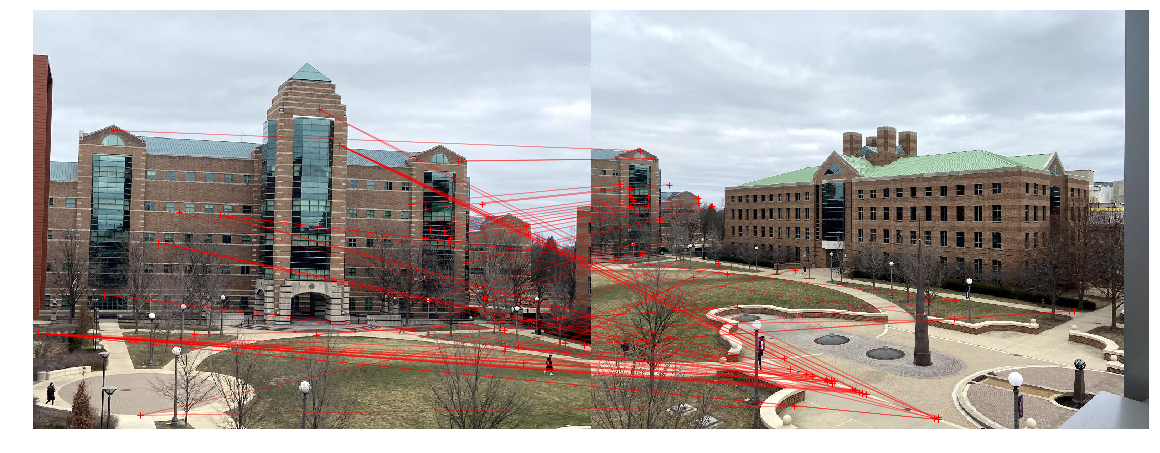

In [35]:
# part (c) compute and display the initial SIFT matching result
data = get_best_matches(gray1, gray2, 300)
# data = get_best_matches(img1, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.pdf', bbox_inches='tight')

Average residual: 2.075660589668713
Inliers: 22


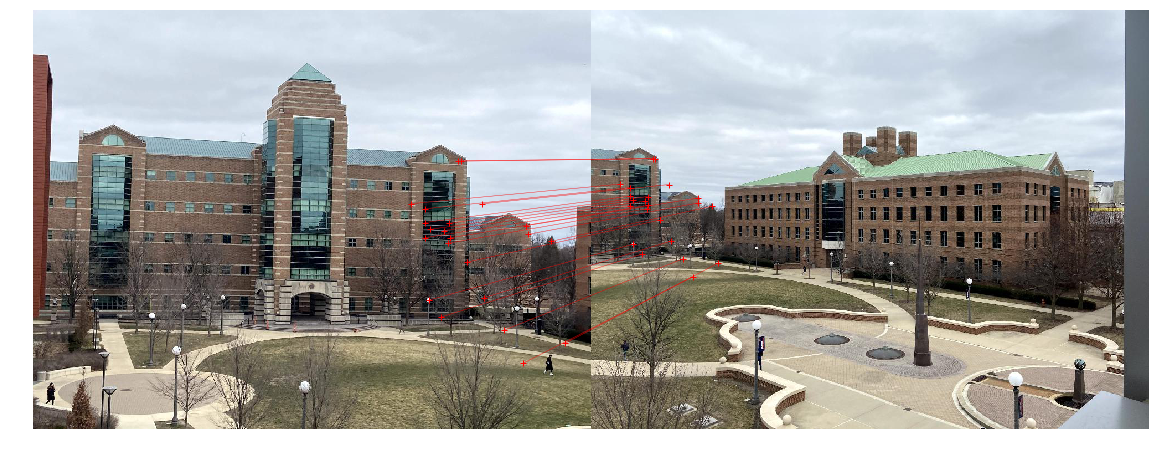

In [36]:
# part (d) performn RANSAC to get the homography and inliers, 
# display the inlier matching, report the average residual
# <YOUR CODE>
H, ransac_match, max_inliers, best_model_errors = ransac(data, 300, 15)
print("Average residual:", np.average(best_model_errors))
print("Inliers:", max_inliers)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, ransac_match)
fig.savefig('ransac_match.pdf', bbox_inches='tight')


offset is  (715, 43)


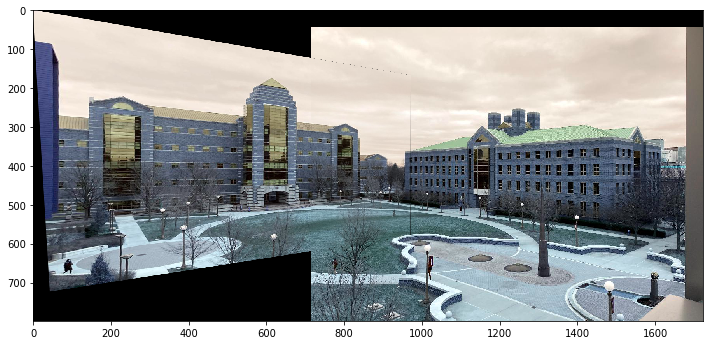

True

In [37]:
# part (e) warp images to stitch them together, 
# display and report the stitching results
# <YOUR CODE>
im = warp_images(img2, img1, H)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(im)
plt.show()
# im = warp_images(gray2, gray1, H)
cv2.imwrite('stitched_images.jpg', im)
# cv2.imwrite('stitched_images.jpg', im, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# cv2.imwrite('stitched_images.jpg', im[:,:,::-1]*255., 
#             [int(cv2.IMWRITE_JPEG_QUALITY), 90])